# Deep-Guitar
This file combines both audio and video models into a single model

### Data Proprocessing 
Audio: Refer to data processing in extract_audio.ipynb

Video: Refer to extract-video.py

### Exploratory Data Analysis

### Audio

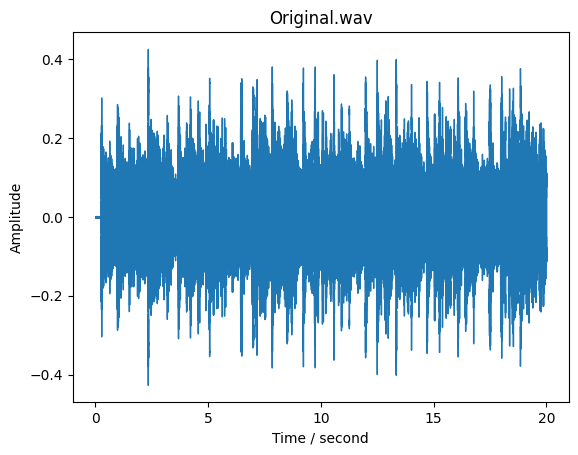

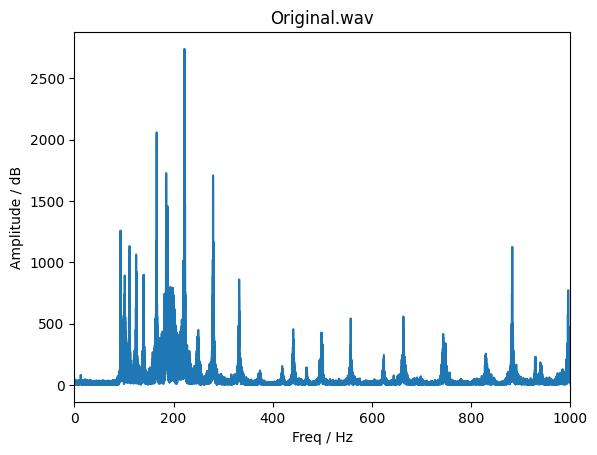

In [1]:
# Display original (anchor) audio and features
from utils.data_visualization import plot_waveform, plot_frquency
import librosa
from IPython.display import Audio
import pandas as pd

audio_filepath = './../dataset_raw/Original.wav'
sample = 'Original.wav'

y, sr = librosa.load(audio_filepath, duration=20)
fig = plot_waveform(y, sr, sample)
plot_frquency(y, sr, sample)

# Playback
Audio(data=y, rate=sr)

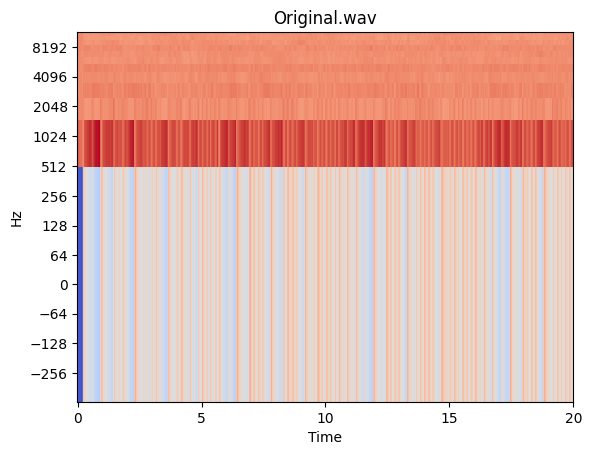

In [2]:
# Plot Mfccs for original image

from utils.data_visualization import plot_chromagram, plot_mel_spectrogram, plot_mfcc
plot_mfcc(y, sr, sample)

### Video

In [3]:
visual_df = pd.read_csv('./../src/data/finger_chords.csv')
visual_df = visual_df.dropna()

visual_df = visual_df.drop(['filename', 'time'], axis=1)
visual_df.head()


,index,middle,ring,pinky,chord
0,0.060992,0.057170,0.047070,0.042153,Em
1,0.068560,0.077840,0.053949,0.050561,G
2,0.039300,0.034916,0.017922,0.012368,G
3,0.040374,0.034587,0.023880,0.015493,G
4,0.031869,0.036160,0.012226,0.015414,G


## Feature Extraction

### Audio

In [4]:
# Generate Feature Matrix for Audio
from utils.audio_feature_extraction import generate_feature_matrix, get_chromagram, get_melspectrogram, get_mfccs
import numpy as np
import os

audio_filepath = './../dataset_raw/Intro/Audio/'

os.listdir(audio_filepath)

features = []
for waveform in os.listdir(audio_filepath):
    waveform_path = audio_filepath + waveform

    y, sr = librosa.load(waveform_path, sr=32000, duration=23)
    df_mfccs, mfccs = get_mfccs(y, sr)

    features.append(df_mfccs.values)

In [5]:
# Generate Audio Features for Anchor and Negative instance

# Anchor Features 
anchor_path = './../dataset_raw/Original.wav'

y, sr = librosa.load(anchor_path, sr=32000, duration=23)
df_mfccs, mfccs = get_mfccs(y, sr)

anchor_feature = df_mfccs.values

# Negative Features 
negative_path = './../dataset_raw/Negative.wav'

y, sr = librosa.load(negative_path, sr=32000, duration=23)
df_mfccs, mfccs = get_mfccs(y, sr)

negative_feature = df_mfccs.values

In [129]:
# Convert matrices to numpy arrays
features = np.asanyarray(features)
negative_feature = np.asanyarray(negative_feature)
anchor_feature = np.asanyarray(anchor_feature)

# Reshape Audio Features
audio_features = np.reshape(features, (features.shape[0], -1))
anchor_feature_matrix = np.reshape(anchor_feature, -1)
negative_feature_matrix = np.reshape(negative_feature, -1)

print(anchor_feature.shape)
print(negative_feature.shape)
print(audio_features.shape)

(12, 12)
(12, 12)
(12, 144)


In [7]:
# Generate Pairs
pairs = []
labels = []

for idx, feature in enumerate(features):

    # Positive Pair
    if(idx % 2 == 0):
        pairs.append([anchor_feature_matrix, feature])
        labels.append(1)
    
    # Negative Pair
    else:
        pairs.append([anchor_feature_matrix, negative_feature_matrix])
        labels.append(0)

X_audio = pairs
Y_audio = labels

### Video
Code for extracting the video is located in extract-video.py

In [8]:
x_video = visual_df.drop(visual_df.columns[4], axis=1)
y_video = visual_df['chord']

## Model Creation

### Audio
References for the model: 
+ https://github.com/sudharsan13296/Hands-On-Meta-Learning-With-Python/blob/master/02.%20Face%20and%20Audio%20Recognition%20using%20Siamese%20Networks/2.5%20Audio%20Recognition%20using%20Siamese%20Network.ipynb
+ https://keras.io/examples/vision/siamese_contrastive/

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_audio, Y_audio, test_size=0.3)

X_train = np.asanyarray(X_train, dtype=np.float32)
y_train = np.asanyarray(y_train, dtype=np.float32)

X_test = np.asanyarray(X_test, dtype=np.float32)
y_test = np.asanyarray(y_test, dtype=np.float32)

In [10]:
# Create Neural Network
from keras import backend as K
from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Flatten
from keras.models import Model
from keras.optimizers import RMSprop

def build_base_network(input_shape):
    input = Input(shape=input_shape)
    x = Flatten(name="flatten_input")(input)
    x = Dense(128, activation='relu', name="first_base_dense")(x)
    x = Dropout(0.1, name="first_dropout")(x)
    x = Dense(128, activation='relu', name="second_base_dense")(x)
    x = Dropout(0.1, name="second_dropout")(x)
    x = Dense(128, activation='relu', name="third_base_dense")(x)

    return Model(inputs=input, outputs=x)

2023-05-03 13:40:58.101120: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-03 13:40:58.121188: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-03 13:40:58.121939: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 13:40:58.761276: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [11]:
# Shape inputs

input_dim = X_train.shape[2:]

audio_a = Input(shape=input_dim)
audio_b = Input(shape=input_dim)

# Create base network

base_network = build_base_network(input_dim)

feat_vecs_a = base_network(audio_a)
feat_vecs_b = base_network(audio_b)

2023-05-03 13:40:59.119318: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-03 13:40:59.134029: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [12]:
# Define euclidean distances

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

# Define loss function
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

# Define parameters
output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])
epochs = 10
rms = RMSprop()

In [13]:
# Define and compile Audio Model
model = Model([audio_a, audio_b], output)
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)

In [14]:
# Train model
history = model.fit([X_train[:,0], X_train[:,1]], y_train, validation_split=.20,
            batch_size=128, epochs=20)

Epoch 1/20
1/1 [==============================] - 1s 560ms/step - loss: 0.4666 - val_loss: 0.9459
Epoch 2/20
1/1 [==============================] - 0s 17ms/step - loss: 0.4384 - val_loss: 0.9261
Epoch 3/20
1/1 [==============================] - 0s 15ms/step - loss: 0.4217 - val_loss: 0.9103
Epoch 4/20
1/1 [==============================] - 0s 16ms/step - loss: 0.3946 - val_loss: 0.8934
Epoch 5/20
1/1 [==============================] - 0s 15ms/step - loss: 0.4000 - val_loss: 0.8735
Epoch 6/20
1/1 [==============================] - 0s 16ms/step - loss: 0.3827 - val_loss: 0.8595
Epoch 7/20
1/1 [==============================] - 0s 16ms/step - loss: 0.3740 - val_loss: 0.8502
Epoch 8/20
1/1 [==============================] - 0s 16ms/step - loss: 0.3732 - val_loss: 0.8338
Epoch 9/20
1/1 [==============================] - 0s 16ms/step - loss: 0.3868 - val_loss: 0.8218
Epoch 10/20
1/1 [==============================] - 0s 16ms/step - loss: 0.3617 - val_loss: 0.8080
Epoch 11/20
1/1 [===========

In [15]:
# Accuracy Calculation (based on fixed distance)

def compute_accuracy(y_true, y_pred):

    pred = y_pred.ravel() > 0.5
    return np.mean(pred == y_true)

(8, 2, 144)

In [16]:
# Results for Audio model

results = model.evaluate([X_test[:,0],X_test[:,1]], y_test, batch_size=128)

y_pred_train = model.predict([X_train[:,0], X_train[:,1]])
train_accuracy = compute_accuracy(y_train, y_pred_train)

y_pred_test = model.predict([X_test[:,0], X_test[:,1]])
test_accuracy = compute_accuracy(y_test, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(results, train_accuracy, test_accuracy))

1/1 [==============================] - 0s 10ms/step
Loss = 0.1975174993276596, Train Accuracy = 0.625 Test Accuracy = 0.25


### Video

In [114]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
x = scale.fit_transform(x_video.values)
x_train, x_test, y_train, y_test = train_test_split(x_video.values, y_video, test_size = 0.3)

In [115]:
# Create Model
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)

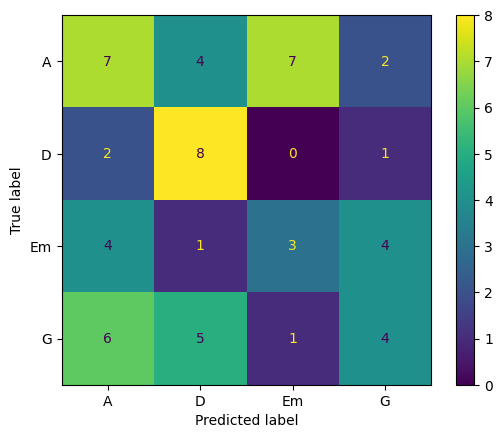

Accuracy: 0.3728813559322034
Classification Report:               precision    recall  f1-score   support

           A       0.37      0.35      0.36        20
           D       0.44      0.73      0.55        11
          Em       0.27      0.25      0.26        12
           G       0.36      0.25      0.30        16

    accuracy                           0.37        59
   macro avg       0.36      0.39      0.37        59
weighted avg       0.36      0.37      0.36        59



In [118]:
# Model Results
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cml = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cml, display_labels=knn.classes_)
disp.plot()
plt.show()

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:', classification_report(y_test, y_pred))

### Combine Models (Late Fusion Style)

In [119]:
# Get predicted Video features
visual_df = pd.read_csv('./../src/data/finger_chords.csv')
visual_df = visual_df.dropna()

video_df = visual_df.drop(visual_df.columns[6], axis=1)

# video_df_unique = video_df.groupby('filename').apply(lambda x: list(np.unique(x)))
# video_df_unique.keys()
video_df


,filename,time,index,middle,ring,pinky
0,Intro9.mp4,1.083333,0.060992,0.057170,0.047070,0.042153
1,Intro9.mp4,2.166667,0.068560,0.077840,0.053949,0.050561
2,Intro9.mp4,3.208333,0.039300,0.034916,0.017922,0.012368
3,Intro9.mp4,7.500000,0.040374,0.034587,0.023880,0.015493
4,Intro9.mp4,8.541667,0.031869,0.036160,0.012226,0.015414
...,...,...,...,...,...,...
198,Intro13.mp4,19.125000,0.090807,0.095109,0.087017,0.078555
199,Intro13.mp4,20.625000,0.077134,0.066720,0.063867,0.061355
200,Intro13.mp4,22.041667,0.095154,0.083075,0.072984,0.067351
201,Intro13.mp4,23.541667,0.092513,0.093924,0.076092,0.069015


In [185]:
video_path = './../dataset_raw/Intro/Video/'
video_list = os.listdir(video_path)

video_x = []
video_y = []
for video in video_list:
    video_hand_features = []
    for idx, row in video_df.iterrows():
        if row['filename'] == video: 
            video_hand_features.append([row['index'], row['middle'], row['ring'], row['pinky']])
        else:
            continue
    if(len(video_hand_features) != 0):
        video_y.append(video)
        video_x.append(video_hand_features)
video_x = np.asanyarray(video_x, dtype=object)

In [123]:
# print(len(video_x))
# print(len(video_y))

video_y

['Intro9.mp4',
 'Intro2.mp4',
 'Intro0.mp4',
 'Intro6.mp4',
 'Intro8.mp4',
 'Intro10.mp4',
 'Intro1.mp4',
 'Intro3.mp4',
 'Intro7.mp4',
 'Intro11.mp4']

In [215]:
# video_path = './../dataset_raw/Intro/Video/'
# video_y = os.listdir(video_path)

scale = StandardScaler()

video_pred = []
for idx, video in enumerate(video_y):
    num = idx
    x = video_x[idx]
    video_pred.append(knn.predict(x))

video_pred = np.asanyarray(video_pred, dtype=object)

In [217]:
# Get predicted Audio Features 

# generate features
audio_filepath = './../dataset_raw/Intro/Audio/'

filenames = os.listdir(audio_filepath)

audio_features = []
audio_labels = []
for waveform in video_y:
    label = waveform[:-4] + '.wav'
    waveform_path = audio_filepath + label

    y, sr = librosa.load(waveform_path, sr=32000, duration=23)
    df_mfccs, mfccs = get_mfccs(y, sr)

    audio_features.append(df_mfccs.values)
    audio_labels.append(label)

print(audio_labels)
audio_features = np.asanyarray(audio_features, dtype=object)
audio_features = np.reshape(audio_features, (audio_features.shape[0], -1))
print(audio_features.shape)



['Intro9.wav', 'Intro2.wav', 'Intro0.wav', 'Intro6.wav', 'Intro8.wav', 'Intro10.wav', 'Intro1.wav', 'Intro3.wav', 'Intro7.wav', 'Intro11.wav']
(10, 144)


In [218]:
# Create pairs

pairs = []
for feature in audio_features:
    pairs.append([anchor_feature_matrix, feature])

x_pairs = np.asarray(pairs, dtype=np.float32)


In [284]:
# Get predictions
y = model.predict([x_pairs[:,0], x_pairs[:,1]])
print(y.shape)

y = np.reshape(y, (-1))
x = video_pred

1/1 [==============================] - 0s 14ms/step
(10, 1)


In [288]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit_transform(video_pred)
# Create Model
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

# encode training
print(mlb.classes_)

# y_train = np.asanyarray(y_train, dtype=object)
# X_train = np.asanyarray(X_train, dtype=object)

# print(X_train.shape)

# knn_combined = KNeighborsClassifier(n_neighbors=3)
# knn_combined.fit(X_train[0], y_train)
# y_pred = knn.predict(X_test)

MultiLabelBinarizer()
